In [3]:
%matplotlib inline 

In [4]:
import os
import json
import csv
import time
from datetime import datetime, timedelta
from numpy import array
import numpy as np
import pandas as pd

import glob
import plotly

from statsmodels.tsa.stattools import adfuller


In [3]:
symbols = ["OTO", "HPT", "AMANAH"]
items = os.listdir("INPUT")
items = [i.split('.')[0] for i in items] 

In [6]:
# symbols = ["OTO", "HPT", "AMANAH","BROCK-W1","SPORT-W5","CEN-W4"]
# symbols = ["SIMAT-W3", "SIMAT-W2", "AMANAH","BROCK-W1","SPORT-W5","CEN-W4","U","SEAOIL-W"]
# symbols = ["APURE","PPS-W1","PK","PPS","ORI"]
symbols = ["ORI","PPS-W1","PK","HTECH","APURE"]
# items = ["2017-03-20", "2017-03-21", "2017-03-22"]
# items = ["2017-03-27","2017-03-28","2017-03-29"]
items = ["2017-03-27"]

In [7]:
def getFreefloat():
    allShare = 250000000
    freeFloat = 67.03
    return (allShare * freeFloat)/100

def check(list):
    if list[1] is not 0 and list[2] is not 0 and list[4] is 0: return 0
    else: return 1

def getSumVol(list):
    # Sum = list[0] + list[1] + list[2] + list[3] + list[4]
    Sum = np.sum(list)
    return Sum

def event(eve):
    if eve == "B":
        return 1
    elif eve == "S":
        return 0
    else:
        return 5

def getTime(time):
    timeSplit = time.split(':')
    return timeSplit

def getDate(Date):
    dateSplit = Date.split('-')
    return dateSplit


def Timestamp2Datetime(Timestamp):
    Datetime = datetime.fromtimestamp(Timestamp-25200).strftime('%Y-%m-%d-%H-%M-%S')
    # print Datetime
    return Datetime

def Datetime2Timestamp(dt, epoch=datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return (td.microseconds + (td.seconds + td.days * 86400) * 10**6) // 10**6


def toTemp(price, vol, eve, symbol):
    sumVO = getSumVol(vol)
    compareBid1[symbol] = tempBid[symbol][5]
    compareOff1[symbol] = tempOffer[symbol][5]


    if eve == 1:

        tempBid[symbol] = price + vol

        difBO[symbol] = sumVO - tempBidVol[symbol]

        if difBO[symbol] <= -1000000:
            volBO[symbol] = -4
        elif -1000000 < difBO[symbol] <= -500000:
            volBO[symbol] = -3
        elif -500000 < difBO[symbol] <= -100000:
            volBO[symbol] = -2
        elif -100000 < difBO[symbol] <= -100:
            volBO[symbol] = -1
        elif -100 < difBO[symbol] <= 100000:
            volBO[symbol] = 1
        elif 100000 < difBO[symbol] <= 500000:
            volBO[symbol] = 2
        elif 500000 < difBO[symbol] <= -1000000:
            volBO[symbol] = 3
        elif difBO[symbol] > 1000000:
            volBO[symbol] = 4

        tempBidVol[symbol] = sumVO
        return price + vol + tempOffer[symbol] + [tempBidVol[symbol]] + [tempOffVol[symbol]]
    else:

        tempOffer[symbol] = price + vol

        difBO[symbol] = sumVO - tempOffVol[symbol]

        if difBO[symbol] <= -1000000:
            volBO[symbol] = -40
        elif -1000000 < difBO[symbol] <= -500000:
            volBO[symbol] = -30
        elif -500000 < difBO[symbol] <= -100000:
            volBO[symbol] = -20
        elif -100000 < difBO[symbol] <= -100:
            volBO[symbol] = -10
        elif -100 < difBO[symbol] <= 100000:
            volBO[symbol] = 10
        elif 100000 < difBO[symbol] <= 500000:
            volBO[symbol] = 20
        elif 500000 < difBO[symbol] <= -1000000:
            volBO[symbol] = 30
        elif difBO[symbol] > 1000000:
            volBO[symbol] = 40

        tempOffVol[symbol] = sumVO
        return tempBid[symbol] + price + vol + [tempBidVol[symbol]] + [tempOffVol[symbol]]



def checkTimestamp(timestamp,symbol):
    if timestamp < tempTimestamp[symbol]:
        return tempTimestamp[symbol],1
    else:
        tempTimestamp[symbol] = timestamp
        return timestamp,0










def getSpread(x):
    ''' x<2         0.01    0
        2<=x<5       0.02    1
        5<=x<10      0.05    2
        10<=x<25     0.1     3
        25<=x<100    0.25    4
        100<=x<200   0.5     5
        200<=x<400   1.0     6
        x>=400       2.0     7
    '''
    if x < 200:
        return 0, 1, 200
    elif 200 <= x < 500:
        return 1, .5, 500
    elif 500 <= x < 1000:
        return 2, .2, 1000
    elif 1000 <= x < 2500:
        return 3, .1, 2500
    elif 2500 <= x < 10000:
        return 4, .04, 10000
    elif 10000 <= x < 20000:
        return 5, .02, 20000
    elif 20000 <= x < 40000:
        return 6, .01, 40000
    else:
        return 7, .005, 40000

def getDifSpread(x1, x2):
    a1, t1, z1 = getSpread(x1)
    a2, t2, z2 = getSpread(x2)
    if a1 == a2:
        Dif = (x2 - x1) * t1
    elif a2 > a1:
        Dif = ((x2 - z1) * t2) + ((z1 - x1) * t1)
    else:
        Dif = -(((x1 - z2) * t1) + ((z2 - x2) * t2))
    return int(Dif)



def calmoney(pbid0,pbid1,pbid2,pbid3,pbid4,vbid0,vbid1,vbid2,vbid3,vbid4):
    money = ((pbid0*vbid0)+(pbid1*vbid1)+(pbid2*vbid2)+(pbid3*vbid3)+(pbid4*vbid4))/100
    return money

In [8]:
idSymbol = dict()
tempBid = dict()
tempOffer = dict()
tempBidVol = dict()
tempOffVol = dict()
tempAll = dict()
priATO = dict()
volATO = dict()
tempTimestamp = dict()
marketStatus = dict()
forTemp = dict()
clearNoise = dict()

sumOrder = dict()
countOrder = dict()

lastPrice = dict()
prior = dict()
highPrice = dict()
lowPrice = dict()
avgPrice = dict()
tradeVol = dict()
buyVol = dict()
sellVol = dict()
auctVol = dict()

spread = dict()
count100k = dict()
count1m = dict()
difBO = dict()

tf30 = dict()
volBO = dict()
typeBO = dict()
compareBid1 = dict()
compareOff1 = dict()


allbidmoney = dict()
sideTransac = dict()



stock =dict()
stock1 =dict()
ato = dict()

tick = dict()

ticklog = dict()
bidtemp = dict()
offertemp = dict()

sumVBidtemp = dict()
sumVOffertemp = dict()

errorlog = dict()
brain = dict()
hasTicker = dict()
hasTransac = dict()
timeTransac = dict()
temptype = dict()

for symbol in symbols:
    # tempBid[symbol] = [None, None, None, None, None, None, None, None, None, None]
    # tempOffer[symbol] = [None, None, None, None, None, None, None, None, None, None]
    tempBid[symbol] = [0,0,0,0,0,0,0,0,0,0,0]
    tempOffer[symbol] = [0,0,0,0,0,0,0,0,0,0,0]
    # forTemp[symbol] = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]

    priATO[symbol] = 0
    volATO[symbol] = 0
    tempTimestamp[symbol] = 0
    marketStatus[symbol] = 0
    clearNoise[symbol] = 0
    idSymbol[symbol] = 0

    sumOrder[symbol] = 0
    countOrder[symbol] = 0

    lastPrice[symbol] = 0
    prior[symbol] = 0
    highPrice[symbol] = 0
    lowPrice[symbol] = 0
    avgPrice[symbol] = 0
    tradeVol[symbol] = 0
    buyVol[symbol] = 0
    sellVol[symbol] = 0
    auctVol[symbol] = 0

    spread[symbol] = 0
    count100k[symbol] = 0
    count1m[symbol] = 0
    difBO[symbol] =0
    tf30[symbol] = 0
    volBO[symbol] = 0
    typeBO[symbol] = 0

    tempBidVol[symbol] = 0
    tempOffVol[symbol] = 0
    compareBid1[symbol] = 0
    compareOff1[symbol] = 0

    allbidmoney[symbol] = 0
    sideTransac[symbol] = 0
    
    stock[symbol] = pd.DataFrame()
    stock1[symbol] = pd.DataFrame()
    ato[symbol] = pd.DataFrame()
    
    tick[symbol] = 0
    
    ticklog[symbol] = pd.DataFrame()
    bidtemp[symbol] = [0,0,0,0,0,0,0,0,0,0]
    offertemp[symbol] = [0,0,0,0,0,0,0,0,0,0]
    sumVBidtemp[symbol] = 0
    sumVOffertemp[symbol] = 0
    
    errorlog[symbol] = pd.DataFrame()
    brain[symbol] = pd.DataFrame()
    
    hasTicker[symbol] = 0
    hasTransac[symbol] = 0
    timeTransac[symbol] = 0
    temptype[symbol] = 0
    
    

    


for symbol in symbols:
    forTemp[symbol] = []

In [9]:
t0 = time.time()
error = 0
dbo = 0

three_tuple = [(current, items[idx - 1] if idx >= 1 else None, items[idx + 1] if idx < len(items) - 1 else None) for idx, current in enumerate(items)]
# return a 3-tuple with current, previous and next elements

for enum, Date in enumerate(items):

    yesterday = three_tuple[enum][1]
    today = three_tuple[enum][0]
    tomorrow = three_tuple[enum][2]
    
    YYYY,MM,DD = getDate(Date)

#     YYYY = int(YYYY)
#     MM = int(MM)
#     DD = int(DD)
    



    with open("INPUT\\" +Date + ".dat") as f:

        content = f.readlines()
        for line in content:
            if 'data' in line:
                try:
                    jsonData = line.replace("data: ", "")
                    jsonDecoded = json.loads(jsonData)
                except ValueError:
                    # print Date, jsonData
#                     errorlog[sym] = errorlog[sym].append({'error':jsonDecoded}, ignore_index=True)
                    error += 1
                    continue
                    
                if 'sym' in jsonDecoded.keys():
                    sym = jsonDecoded["sym"]
                    if sym in symbols:
                        if 'isf' in jsonDecoded.keys():
                            isf = jsonDecoded["isf"]
                            
                            priATO[sym] = pri = jsonDecoded["pri"] 
                            
                            volATO[sym] = vol = jsonDecoded["vol"]
                            
                            HH, mm, SS = getTime(jsonDecoded["tim"])
                            HH = int(HH)
                            mm = int(mm)
                            SS = int(SS)
                            
                            if isf == 'F':
                                marketStatus[sym] = 0 
                                if HH == 14:
                                    marketStatus[sym] = 2
                                if HH == 16:
                                    marketStatus[sym] = 3
                                    
                            elif isf == 'T':
                                if HH == 16 and mm >30:
                                    marketStatus[sym] = 4  
                            
                        elif 'time' in jsonDecoded.keys():
                            Id = jsonDecoded["id"]
                            tim = checkTimestamp(jsonDecoded["time"],sym)                            
                            
                            sid = jsonDecoded["sid"]
                            pri = jsonDecoded["pri"]
                            vol = jsonDecoded["vol"]
                            sumVol = getSumVol(vol)
                            
                            
                            hasTransac[sym] = 0
                            if timeTransac[sym] == tim[0] :
                                hasTransac[sym] = 1
                            
                            
                            if marketStatus[sym] == 1:
                                spread[sym] = getDifSpread(offertemp[sym][0],bidtemp[sym][0])
                            
                            
                            if pri[4] == 0:
#                                 errorlog[sym] = errorlog[sym].append({'error':jsonDecoded}, ignore_index=True)
#                                 error += 1
                                continue
                            
                            if pri[0] == 0:
                                pri[0] = priATO[sym]
                            
#                             if hasTicker[sym] == 1:
#                                 if lastPrice[sym] != pri[0]:
#                                     if sideTransac[sym] == 'B':
#                                         temptype[sym] ="RuabOffer"
#                                     else:
#                                         temptype[sym] = "RuabBid"
                                    
#                                 else:
#                                     if sideTransac[sym] == 'B':
#                                         temptype[sym] = "Buy"
#                                     elif sideTransac[sym] == 'S':
#                                         temptype[sym] = "Sell"
#                                     else:
#                                         temptype[sym] = "U"
                            if hasTicker[sym] == 1:
                                typeBO[sym] = 1
                                if sideTransac[sym] == 'B':
                                    temptype[sym] = "Buy Partial"
                                    if offertemp[sym][5] <= sumOrder[sym]:
                                        typeBO[sym] = 3
                                        temptype[sym] ="Buy All"
                                
                                elif sideTransac[sym] == 'S':
                                    temptype[sym] = "Sell Partial"
                                    if bidtemp[sym][5] <= sumOrder[sym]:
                                        typeBO[sym] = 3
                                        temptype[sym] = "Sell All"
                            
                                else:
                                        temptype[sym] = "U"
                                                                                
                                    
                                hasTransac[sym] = 1
                                
                                if marketStatus[sym] == 1:
                                    brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sideTransac[sym], 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym], 9:'0', 10:spread[sym], 11:bidtemp[sym][0], 12:offertemp[sym][0], 13:typeBO[sym], 14:prior[sym], 15:highPrice[sym], 16:lowPrice[sym], 17:avgPrice[sym], 18:sumVBidtemp[sym], 19:sumVOffertemp[sym]}, ignore_index=True)
#                                 brain[sym] = brain[sym].append({'Id':Id, 'date':Date, 'time':tim[0], 'mks':marketStatus[sym], 'side':sideTransac[sym], 'sum':sumOrder[sym], 'count':countOrder[sym], 'last':lastPrice[sym], 'atype':temptype[sym], 'diffbo':dbo}, ignore_index=True)

                            
                            
                            
                            sumOrder[sym] = 0
                            countOrder[sym] = 0
                            hasTicker[sym] = 0

#                             stock[sym] = stock[sym].append({'sumvol': sumVol,'spread':spread[sym], 'sumOrder':sumOrder[sym], 'countOrder':countOrder[sym], 'btemp':bidtemp[sym] , 'otemp': offertemp[sym], 'marketStatus': marketStatus[sym], 'Id':Id, 'date':Date, 'time':tim[0], 'side':sid, 'p0':pri[0], 'p1':pri[1], 'p2':pri[2], 'p3':pri[3], 'p4':pri[4], 'v0':vol[0], 'v1':vol[1], 'v2':vol[2], 'v3':vol[3], 'v4':vol[4]}, ignore_index=True)
#                             stock[sym] = stock[sym].append({'0':Id, '1':Date, '2':tim[0], '3': marketStatus[sym], '4':sid, '5':bidtemp[sym], '6': offertemp[sym], '7':sumOrder[sym], '8':countOrder[sym], '9':spread[sym], '10':sumVol, '11':pri[0], '12':pri[1], '13':pri[2], '14':pri[3], '15':pri[4], '16':vol[0], '17':vol[1], '18':vol[2], '19':vol[3], '20':vol[4]}, ignore_index=True)

#                             if marketStatus[sym] == 1:
#                                 stock[sym] = stock[sym].append({0:Id, 1:Date, 2:tim[0], 3: marketStatus[sym], 4:sid, 5:bidtemp[sym], 6: offertemp[sym], 7:sumOrder[sym], 8:countOrder[sym], 9:spread[sym], 10:sumVol, 11:pri[0], 12:pri[1], 13:pri[2], 14:pri[3], 15:pri[4], 16:vol[0], 17:vol[1], 18:vol[2], 19:vol[3], 20:vol[4]}, ignore_index=True)

    
#                             sumOrder[sym] = 0
#                             countOrder[sym] = 0
    
                            if hasTransac[sym] == 0:
                                if sid == 'S':
                                    if offertemp[sym][5] == vol[0]:
                                        typeBO[sym] = 0
                                    else:
                                        typeBO[sym] = 1
                        
                                    if offertemp[sym][0] == pri[0]:
                                        dbo = abs(sumVol-sumVOffertemp[sym])
                                        if sumVol > sumVOffertemp[sym]:
                                            temptype[sym] = "Add Offer Partial"
                                        elif sumVol < sumVOffertemp[sym]:
                                            temptype[sym] = "Remove Offer Partial"
                                        else:
                                            temptype[sym] = "Eq Offer"

                                    else:
                                        typeBO[sym] = 2
                                        if offertemp[sym][0] > pri[0]:
                                            dbo = vol[0]
                                            temptype[sym] = "Add First Offer Hurry."
#                                             if pri[0] == lastPrice[sym]:
#                                                 temptype[sym] = "Rest of Sell"

                                        elif offertemp[sym][0] < pri[0]:
                                            dbo = offertemp[sym][5]
                                            temptype[sym] = "Remove First Offer Hurry."
                        
                                        else:
                                            temptype[sym] = "Bug at Offer"
                            
    
                                    if marketStatus[sym] == 1:
                                        brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym], 9:dbo, 10:spread[sym], 11:bidtemp[sym][0], 12:offertemp[sym][0], 13:typeBO[sym],14:prior[sym], 15:highPrice[sym], 16:lowPrice[sym], 17:avgPrice[sym], 18:sumVBidtemp[sym], 19:sumVOffertemp[sym]}, ignore_index=True)
#                                     brain[sym] = brain[sym].append({'Id':Id, 'date':Date, 'time':tim[0], 'mks':marketStatus[sym], 'side':sid, 'sum':sumOrder[sym], 'count':countOrder[sym], 'last':lastPrice[sym], 'atype':temptype[sym], 'diffbo':dbo}, ignore_index=True)

                                    offertemp[sym] = pri + vol
                                    sumVOffertemp[sym] = sumVol

                                elif sid == 'B':
                                    if bidtemp[sym][5] == vol[0]:
                                        typeBO[sym] = 0
                                    else:
                                        typeBO[sym] = 1
                        
                                    if bidtemp[sym][0] == pri[0]:
                                        dbo = abs(sumVol-sumVBidtemp[sym])
                                        if sumVol > sumVBidtemp[sym]:
                                            temptype[sym] = "Add Bid Partial"
                                        elif sumVol < sumVBidtemp[sym]:
                                            temptype[sym] = "Remove Bid Partial"
                                        else:
                                            temptype[sym] = "Eq Bid"
                                    else:
                                        typeBO[sym] = 2
                                        if bidtemp[sym][0] < pri[0]:
                                            dbo = vol[0]
                                            temptype[sym] = "Add First Bid Hurry."
#                                             if pri[0] == lastPrice[sym]:
#                                                 temptype[sym] = "Rest of Buy"

                                        elif bidtemp[sym][0] > pri[0]:
                                            dbo = bidtemp[sym][5]
                                            temptype[sym] = "Remove First Bid Hurry."
                                        
                                        else:
                                            temptype[sym] = "Bug at Bid"
                                        
                                        

                                    if marketStatus[sym] == 1:
                                        brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym], 9:dbo, 10:spread[sym], 11:bidtemp[sym][0], 12:offertemp[sym][0], 13:typeBO[sym], 14:prior[sym], 15:highPrice[sym], 16:lowPrice[sym], 17:avgPrice[sym], 18:sumVBidtemp[sym], 19:sumVOffertemp[sym]}, ignore_index=True)    
#                                     brain[sym] = brain[sym].append({'Id':Id, 'date':Date, 'time':tim[0], 'mks':marketStatus[sym], 'side':sid, 'sum':sumOrder[sym], 'count':countOrder[sym], 'last':lastPrice[sym], 'atype':temptype[sym], 'diffbo':dbo}, ignore_index=True)

                                    bidtemp[sym] = pri + vol
                                    sumVBidtemp[sym] = sumVol


                                else:
                                    print jsonData, "in bid offer temp"
                                    error += 1
                                    continue
                            
                            else:
                                typeBO[sym] = 2
                                if sid == 'S':
#                                     temptype[sym] = "Fix it at S"
                                    if lastPrice[sym] == pri[0] and sideTransac[sym] == 'S':
                                        temptype[sym] = "Sell then Offer"
                                        dbo = vol[0]
                                        if marketStatus[sym] == 1:
                                            brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym], 9:dbo, 10:spread[sym], 11:bidtemp[sym][0], 12:offertemp[sym][0], 13:typeBO[sym], 14:prior[sym], 15:highPrice[sym], 16:lowPrice[sym], 17:avgPrice[sym], 18:sumVBidtemp[sym], 19:sumVOffertemp[sym]}, ignore_index=True)
#                                         brain[sym] = brain[sym].append({'Id':Id, 'date':Date, 'time':tim[0], 'mks':marketStatus[sym], 'side':sid, 'sum':sumOrder[sym], 'count':countOrder[sym], 'last':lastPrice[sym], 'atype':temptype[sym], 'diffbo':dbo}, ignore_index=True)

                                    offertemp[sym] = pri + vol
                                    sumVOffertemp[sym] = sumVol
                                elif sid == 'B':
#                                     temptype[sym] = "Fix it at B"
                                    if lastPrice[sym] == pri[0] and sideTransac[sym] == 'B':
                                        temptype[sym] = "Buy then Bid"
                                        dbo = vol[0]
                                        if marketStatus[sym] == 1:
                                            brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym], 9:dbo, 10:spread[sym], 11:bidtemp[sym][0], 12:offertemp[sym][0], 13:typeBO[sym], 14:prior[sym], 15:highPrice[sym], 16:lowPrice[sym], 17:avgPrice[sym], 18:sumVBidtemp[sym], 19:sumVOffertemp[sym]}, ignore_index=True)
#                                         brain[sym] = brain[sym].append({'Id':Id, 'date':Date, 'time':tim[0], 'mks':marketStatus[sym], 'side':sid, 'sum':sumOrder[sym], 'count':countOrder[sym], 'last':lastPrice[sym], 'atype':temptype[sym], 'diffbo':dbo}, ignore_index=True)

                                    bidtemp[sym] = pri + vol
                                    sumVBidtemp[sym] = sumVol
                                else:
                                    print jsonData, "in bid offer temp"
                                    error += 1
                                    continue
#                                 brain[sym] = brain[sym].append({0:Id, 1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:sumOrder[sym], 6:countOrder[sym], 7:lastPrice[sym], 8:temptype[sym]}, ignore_index=True)
                                
                                

#                                 stock[sym] = stock[sym].append({'tf30':tf30[sym], 'Timestamp':Timestamp[0], 'Date':Date}, ignore_index=True)


                        elif 'ava' in jsonDecoded.keys():
                            marketStatus[sym] = 1
            
                            tim = jsonDecoded["tim"]  
                            tim = checkTimestamp(tim,sym)
            
            
            
                            actVol = jsonDecoded["vol"] 
                            sideTransac[sym] = sid = jsonDecoded["sid"]
                            lastPrice[sym] = prc = jsonDecoded["prc"]
                            prior[sym] = prr = jsonDecoded["prr"]  
                            
                            highPrice[sym] = hgh = jsonDecoded["hgh"]
                            lowPrice[sym] = low = jsonDecoded["low"] 
                            avgPrice[sym] = avg = jsonDecoded["avg"]
                            
                            tradeVol[sym] = avo = jsonDecoded["avo"]
                            buyVol[sym] = bvo = jsonDecoded["bvo"]
                            sellVol[sym] = svo = jsonDecoded["svo"]
                            
                            tick[sym] +=1
                            
                            
                            sumOrder[sym] += actVol
                            countOrder[sym] += 1
                            hasTicker[sym] = 1

                            timeTransac[sym] = tim[0]
                            

                            
#                             stock[sym] = stock[sym].append({'sumvol': 0 ,'spread':spread[sym], 'sumOrder':sumOrder[sym], 'countOrder':countOrder[sym], 'btemp':bidtemp[sym] , 'otemp': offertemp[sym], 'marketStatus': marketStatus[sym], 'tick':tick[sym], 'actVol':actVol, 'date':Date, 'time':tim[0], 'side':sid, 'last':prc, 'prior':prr, 'high':hgh, 'low':low, 'average':avg,'tradevol':avo,'buyvol':bvo,'sellvol':svo }, ignore_index=True)
#                             stock[sym] = stock[sym].append({'1':Date, '2':tim[0], '3':marketStatus[sym], '4':sid, '5':bidtemp[sym], '6':offertemp[sym], '7':sumOrder[sym], '8':countOrder[sym],'9':spread[sym], '10': 0, '21':tick[sym], '22':actVol, '23':prc, '24':prr, '25':hgh, '26':low, '27':avg,'28':avo,'29':bvo,'30':svo }, ignore_index=True)

#                             if marketStatus[sym] == 1:        
#                                 stock[sym] = stock[sym].append({1:Date, 2:tim[0], 3:marketStatus[sym], 4:sid, 5:bidtemp[sym], 6:offertemp[sym], 7:sumOrder[sym], 8:countOrder[sym],9:spread[sym], 10: 0, 21:tick[sym], 22:actVol, 23:prc, 24:prr, 25:hgh, 26:low, 27:avg,28:avo,29:bvo,30:svo }, ignore_index=True)
                            
                        else:
                            continue


        for sym in symbols:
            tempTimestamp[sym] = 0
            
        t1 = time.time()
        total = t1-t0
        for sym in symbols:
            tick[sym] = 0

        print Date, total, "seconds from start time.", " :error = ",error
        
#         for sym in symbols:
#             brain[sym].to_csv("stock\\" +sym+"\\many\\"+Date+'brain.csv')
#             brain[sym] = pd.DataFrame()
#             marketStatus[sym] = 0
print "finished."


2017-03-27 167.486000061 seconds from start time.  :error =  0
finished.


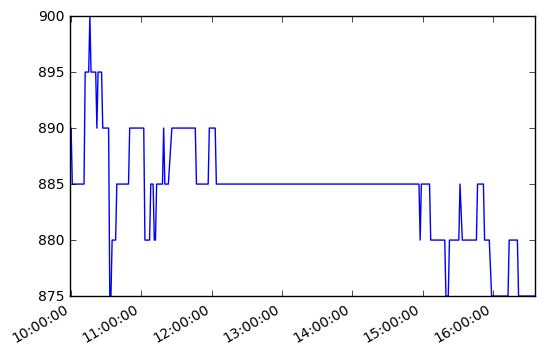

In [64]:
dt1['HTECH'].close.plot()

In [72]:
dt30['PK']

,open,high,low,close,predict
2017-03-27 10:00:00,354.0,354.0,354.0,354.0,354.0
2017-03-27 10:30:00,354.0,354.0,354.0,354.0,353.0
2017-03-27 11:00:00,354.0,354.0,352.0,352.0,353.0
2017-03-27 11:30:00,352.0,354.0,352.0,354.0,354.0
2017-03-27 12:00:00,354.0,354.0,354.0,354.0,352.0
2017-03-27 14:00:00,352.0,352.0,352.0,352.0,352.0
2017-03-27 14:30:00,352.0,352.0,352.0,352.0,353.0
2017-03-27 15:00:00,352.0,354.0,352.0,354.0,353.0
2017-03-27 15:30:00,354.0,354.0,352.0,352.0,351.0
2017-03-27 16:00:00,352.0,352.0,350.0,350.0,NaN


In [37]:
dt1['PK']['predict'][-1] =dt1['PK']['predict'][1]

In [20]:
dt = dict()
dt1 = dict()
dt5 = dict()
dt30 = dict()
dt60 = dict()
dtD = dict()

for sym in symbols:
    brain[sym]['Datetime'] = pd.to_datetime(brain[sym][1] + ' ' + brain[sym][2])
    dt[sym] = brain[sym].set_index(pd.DatetimeIndex(brain[sym]['Datetime']))
    
    dt1[sym] = dt[sym][7].resample('1min').ohlc().between_time('09:30', '16:40').dropna()
    dt5[sym] = dt[sym][7].resample('5min').ohlc().between_time('09:30', '16:40').dropna()
    dt30[sym] = dt[sym][7].resample('30min').ohlc().between_time('09:30', '16:40').dropna()
    dt60[sym] = dt[sym][7].resample('60min').ohlc().between_time('09:30', '16:40').dropna()
    dtD[sym] = dt[sym][7].resample('D').ohlc().dropna()
    

In [73]:
def getAvgOHLC(df):
    return round((df.open + df.high + df.low + df.close)/4, 0)

def getHigh(df):
    return df.high

def getLow(df):
    return df.low

# (dt['PK'].open + dt['PK'].high + dt['PK'].low + dt['PK'].close)/4

In [22]:
for sym in symbols:
    #OHLC/4 Method 
    dt1[sym]['predict'] = dt1[sym].apply(lambda x : getAvgOHLC(x), axis = 1).shift(-1)
    dt5[sym]['predict'] = dt5[sym].apply(lambda x : getAvgOHLC(x), axis = 1).shift(-1)
    dt30[sym]['predict'] = dt30[sym].apply(lambda x : getAvgOHLC(x), axis = 1).shift(-1)
    dt60[sym]['predict'] = dt60[sym].apply(lambda x : getAvgOHLC(x), axis = 1).shift(-1)
    dtD[sym]['predict'] = dtD[sym].apply(lambda x : getAvgOHLC(x), axis = 1).shift(-1)

In [78]:
for sym in symbols:
    dt1[sym]['LOWL'] = dt1[sym].apply(lambda x : getLow(x), axis = 1).shift(2)

In [162]:
aabb = zaz.resample('30min').sum().dropna()



In [161]:
dt30['ORI']

,open,high,low,close,predict
2017-03-27 09:30:00,1080.0,1080.0,1080.0,1080.0,1078.0
2017-03-27 10:00:00,1080.0,1080.0,1070.0,1080.0,1075.0
2017-03-27 10:30:00,1080.0,1080.0,1070.0,1070.0,1073.0
2017-03-27 11:00:00,1070.0,1080.0,1070.0,1070.0,1070.0
2017-03-27 11:30:00,1070.0,1070.0,1070.0,1070.0,1068.0
2017-03-27 12:00:00,1070.0,1080.0,1050.0,1070.0,1060.0
2017-03-27 14:00:00,1060.0,1060.0,1060.0,1060.0,1063.0
2017-03-27 14:30:00,1060.0,1070.0,1050.0,1070.0,1063.0
2017-03-27 15:00:00,1070.0,1070.0,1050.0,1060.0,1055.0
2017-03-27 15:30:00,1060.0,1060.0,1050.0,1050.0,1058.0


In [169]:
bbaa = aabb.join(dt30['ORI'])
bbaa = bbaa.dropna()
bbaa

,Add Bid Partial,Add First Bid Hurry.,Add First Offer Hurry.,Add Offer Partial,Buy All,Buy Partial,Buy then Bid,Remove Bid Partial,Remove First Offer Hurry.,Remove Offer Partial,Sell All,Sell Partial,Sell then Offer,U,open,high,low,close,predict
2017-03-27 09:30:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1080.0,1080.0,1080.0,1080.0,1078.0
2017-03-27 10:00:00,16.0,0.0,0.0,25.0,0.0,10.0,0.0,17.0,0.0,5.0,0.0,1.0,0.0,0.0,1080.0,1080.0,1070.0,1080.0,1075.0
2017-03-27 10:30:00,24.0,0.0,0.0,17.0,0.0,12.0,0.0,13.0,0.0,13.0,0.0,6.0,0.0,0.0,1080.0,1080.0,1070.0,1070.0,1073.0
2017-03-27 11:00:00,8.0,0.0,0.0,19.0,0.0,24.0,0.0,36.0,0.0,14.0,0.0,27.0,0.0,0.0,1070.0,1080.0,1070.0,1070.0,1070.0
2017-03-27 11:30:00,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1070.0,1070.0,1070.0,1070.0,1068.0
2017-03-27 12:00:00,46.0,1.0,1.0,35.0,3.0,21.0,5.0,25.0,0.0,20.0,5.0,25.0,4.0,0.0,1070.0,1080.0,1050.0,1070.0,1060.0
2017-03-27 14:00:00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1060.0,1060.0,1060.0,1060.0,1063.0
2017-03-27 14:30:00,43.0,1.0,0.0,48.0,3.0,19.0,3.0,10.0,1.0,37.0,6.0,14.0,6.0,0.0,1060.0,1070.0,1050.0,1070.0,1063.0
2017-03-27 15:00:00,17.0,0.0,0.0,41.0,0.0,15.0,0.0,12.0,0.0,33.0,1.0,9.0,1.0,0.0,1070.0,1070.0,1050.0,1060.0,1055.0
2017-03-27 15:30:00,22.0,0.0,0.0,36.0,1.0,26.0,0.0,19.0,0.0,28.0,0.0,9.0,0.0,0.0,1060.0,1060.0,1050.0,1050.0,1058.0


In [140]:
zaz.dropna()

D:\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning:

.resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)



,Add Bid Partial,Add First Offer Hurry.,Add Offer Partial,Buy All,Buy Partial,Buy then Bid,Remove Bid Partial,Remove Offer Partial,Sell All,Sell Partial,Sell then Offer,U
2017-03-27 10:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,0.0
2017-03-27 10:22:00,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.50,0.0,0.0
2017-03-27 10:23:00,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.50,0.0,0.0
2017-03-27 10:26:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2017-03-27 10:46:00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.50,0.0,0.0
2017-03-27 10:51:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,0.0
2017-03-27 10:52:00,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.50,0.0,0.0
2017-03-27 11:02:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2017-03-27 11:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,0.0
2017-03-27 11:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.00,0.5,0.0


In [152]:
zaz = pd.get_dummies(brain['ORI'][8])
# pd.get_dummies(brain['ORI'][8])

In [132]:
zaz = zaz.set_index(pd.DatetimeIndex(zaz['Datetime']))


In [153]:
zaz = zaz.join(brain['ORI']['Datetime'])
zaz = zaz.set_index(pd.DatetimeIndex(zaz['Datetime']))


In [154]:
zaz

,Add Bid Partial,Add First Bid Hurry.,Add First Offer Hurry.,Add Offer Partial,Buy All,Buy Partial,Buy then Bid,Remove Bid Partial,Remove First Offer Hurry.,Remove Offer Partial,Sell All,Sell Partial,Sell then Offer,U,Datetime
2017-03-27 09:59:31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-03-27 09:59:31
2017-03-27 09:59:47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 09:59:47
2017-03-27 10:00:07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:00:07
2017-03-27 10:01:20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:01:20
2017-03-27 10:01:23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:01:23
2017-03-27 10:01:54,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:01:54
2017-03-27 10:03:30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:03:30
2017-03-27 10:05:20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:05:20
2017-03-27 10:05:27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:05:27
2017-03-27 10:05:31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-03-27 10:05:31


In [217]:
# brain['PPS-W1'][9] = pd.to_numeric(brain['PPS-W1'][9])

brain['PPS-W1'][8]

numpy.float64

In [208]:
dt['PPS-W1']

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Datetime
2017-03-27 09:59:30,20155,2017-03-27,09:59:30,1.0,U,1099500.0,1.0,106.0,U,0,...,106.0,106.0,1.0,105.0,106.0,106.0,106.0,1250900.0,1474200.0,2017-03-27 09:59:30
2017-03-27 09:59:39,20155,2017-03-27,09:59:39,1.0,B,110000.0,3.0,106.0,Buy Partial,0,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,894200.0,2017-03-27 09:59:39
2017-03-27 09:59:39,20155,2017-03-27,09:59:39,1.0,B,3000.0,1.0,106.0,Buy Partial,0,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,784200.0,2017-03-27 09:59:39
2017-03-27 09:59:47,20155,2017-03-27,09:59:47,1.0,S,0.0,0.0,106.0,Add Offer Partial,1500,...,105.0,106.0,0.0,105.0,106.0,106.0,106.0,752100.0,781200.0,2017-03-27 09:59:47
2017-03-27 09:59:52,20155,2017-03-27,09:59:52,1.0,B,73000.0,3.0,106.0,Buy Partial,0,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,782700.0,2017-03-27 09:59:52
2017-03-27 09:59:53,20155,2017-03-27,09:59:53,1.0,B,50000.0,2.0,106.0,Buy Partial,0,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,709700.0,2017-03-27 09:59:53
2017-03-27 09:59:57,20155,2017-03-27,09:59:57,1.0,B,10000.0,1.0,106.0,Buy Partial,0,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,659700.0,2017-03-27 09:59:57
2017-03-27 09:59:59,20155,2017-03-27,09:59:59,1.0,S,0.0,0.0,106.0,Add Offer Partial,60000,...,105.0,106.0,1.0,105.0,106.0,106.0,106.0,752100.0,699700.0,2017-03-27 09:59:59
2017-03-27 09:59:59,20155,2017-03-27,09:59:59,1.0,S,0.0,0.0,106.0,Remove Offer Partial,60000,...,105.0,106.0,0.0,105.0,106.0,106.0,106.0,752100.0,759700.0,2017-03-27 09:59:59
2017-03-27 10:00:01,20155,2017-03-27,10:00:01,1.0,S,0.0,0.0,106.0,Add Offer Partial,50000,...,105.0,106.0,0.0,105.0,106.0,106.0,106.0,752100.0,699700.0,2017-03-27 10:00:01


In [12]:
dt['PPS-W1'].groupby(pd.TimeGrouper(freq='30Min')).sum()

,open,high,low,close
2017-03-27 09:30:00,106.0,106.0,106.0,106.0
2017-03-27 10:00:00,106.0,108.0,105.0,105.0
2017-03-27 10:30:00,105.0,106.0,105.0,106.0
2017-03-27 11:00:00,106.0,106.0,105.0,106.0
2017-03-27 11:30:00,106.0,106.0,106.0,106.0
2017-03-27 12:00:00,106.0,106.0,105.0,105.0
2017-03-27 12:30:00,NaN,NaN,NaN,NaN
2017-03-27 13:00:00,NaN,NaN,NaN,NaN
2017-03-27 13:30:00,NaN,NaN,NaN,NaN
2017-03-27 14:00:00,105.0,105.0,105.0,105.0


In [19]:
# dt['PPS-W1'].groupby(0).shift(-1)
ss =dt['PPS-W1'].groupby(pd.TimeGrouper(freq='30Min')).sum().shift(-1).dropna()


In [57]:
ss.loc['2017-03-27 10:00:00'].high


def getIndex(x):
    return x.index


In [85]:
# dt['PPS-W1'].loc['2017-03-27 09:30:00':'2017-03-27 11:00:00'].apply(ss.loc['2017-03-27 09:30:00'].high)
dt['PPS-W1']  = dt['PPS-W1'].apply(lambda x: getIndex(x), axis = 1)
# dt['PPS-W1']

In [94]:
dt['PPS-W1'].groupby('user_id').apply(my_stat_function)

KeyError: 'index'

In [29]:
ss.loc['2017-03-27 09:30:00'].high

In [37]:
row_iterator.next()

(24, 0               20155
 1          2017-03-27
 2            10:00:28
 3                   1
 4                   B
 5                   0
 6                   0
 7                 107
 8     Add Bid Partial
 9              100000
 10                 -1
 11                106
 12                107
 13                  1
 14                105
 15                107
 16                106
 17                106
 18             678400
 19             965400
 Name: 24, dtype: object)

In [66]:
# dt['PPS-W1'].loc['2017-03-27 09:59:30':'2017-03-27 12:59:40']

ss =dt['PPS-W1'].groupby(pd.TimeGrouper(freq='30Min'))

In [74]:
ss['open'].aggregate(np.sum)

2017-03-27 09:30:00      742.0
2017-03-27 10:00:00    15531.0
2017-03-27 10:30:00    11253.0
2017-03-27 11:00:00     4131.0
2017-03-27 11:30:00     3816.0
2017-03-27 12:00:00      843.0
2017-03-27 12:30:00        NaN
2017-03-27 13:00:00        NaN
2017-03-27 13:30:00        NaN
2017-03-27 14:00:00      210.0
2017-03-27 14:30:00     1680.0
2017-03-27 15:00:00     5565.0
2017-03-27 15:30:00     4905.0
2017-03-27 16:00:00    10285.0
2017-03-27 16:30:00      104.0
2017-03-27 17:00:00        NaN
2017-03-27 17:30:00        NaN
2017-03-27 18:00:00        NaN
2017-03-27 18:30:00        NaN
2017-03-27 19:00:00        NaN
2017-03-27 19:30:00        NaN
2017-03-27 20:00:00        NaN
2017-03-27 20:30:00        NaN
2017-03-27 21:00:00        NaN
2017-03-27 21:30:00        NaN
2017-03-27 22:00:00        NaN
2017-03-27 22:30:00        NaN
2017-03-27 23:00:00        NaN
2017-03-27 23:30:00        NaN
2017-03-28 00:00:00        NaN
                        ...   
2017-03-29 02:00:00        NaN
2017-03-

In [60]:
dt['PPS-W1'].loc['2017-03-29 09:50:30':'2017-03-29 12:59:40']

,open,high,low,close
2017-03-29 09:58:23,106.0,106.0,106.0,106.0
2017-03-29 09:58:50,106.0,106.0,106.0,106.0
2017-03-29 09:58:51,106.0,106.0,106.0,106.0
2017-03-29 09:58:54,106.0,106.0,106.0,106.0
2017-03-29 09:59:13,106.0,106.0,106.0,106.0
2017-03-29 09:59:25,106.0,106.0,106.0,106.0
2017-03-29 09:59:40,106.0,106.0,106.0,106.0
2017-03-29 09:59:45,106.0,106.0,106.0,106.0
2017-03-29 09:59:49,106.0,106.0,106.0,106.0
2017-03-29 09:59:52,106.0,106.0,106.0,106.0


In [65]:
ss.count()

,open,high,low,close
2017-03-27 09:59:00,7,7,7,7
2017-03-27 10:00:00,21,21,21,21
2017-03-27 10:01:00,17,17,17,17
2017-03-27 10:02:00,12,12,12,12
2017-03-27 10:03:00,10,10,10,10
2017-03-27 10:04:00,7,7,7,7
2017-03-27 10:05:00,4,4,4,4
2017-03-27 10:06:00,9,9,9,9
2017-03-27 10:07:00,5,5,5,5
2017-03-27 10:08:00,2,2,2,2


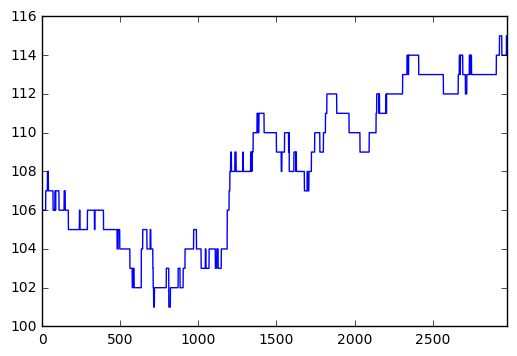

In [7]:
brain['PPS-W1'][7].plot()

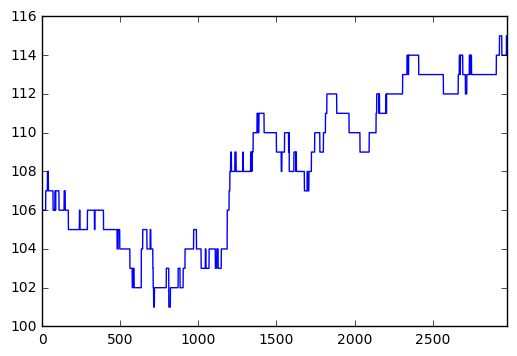

In [9]:
brain['PPS-W1'][7].plot()

In [16]:
dt = dict()

for sym in symbols:
    stock[sym]['Datetime'] = pd.to_datetime(stock[sym]['date'] + ' ' + stock[sym]['time'])
    dt[sym] = stock[sym].set_index(pd.DatetimeIndex(stock[sym]['Datetime']))
    
#     dt[sym] = dt[sym].loc[(dt[sym]['marketStatus'] == 1) & (dt[sym]['p4'] != 0)]
    dt[sym] = dt[sym].loc[(dt[sym]['mks'] == 1)]
    
    brain[sym] = brain[sym].loc[(brain[sym][3] == 1)]
    

KeyError: 'date'

In [25]:


for sym in symbols:
#     errorlog[sym].to_csv("stock\\" +sym+'error.csv')
    
    stock[sym].to_csv("stock\\" +sym+'2.csv')
#     dt[sym].to_csv("stock\\" +sym+'1.csv')
    brain[sym].to_csv("stock\\" +sym+'brain2.csv')

In [232]:
dt[sym].loc[(dt[sym]['marketStatus'] == 1) & (dt[sym]['p4'] != 0)]

,Id,date,marketStatus,p0,p1,p2,p3,p4,side,time,...,average,buyvol,high,last,low,prior,sellvol,tick,tradevol,Datetime
2017-02-16 09:57:44,NaN,2017-02-16,1.0,NaN,NaN,NaN,NaN,NaN,U,09:57:44,...,165.0,0.0,165.0,165.0,165.0,165.0,0.0,1.0,114300.0,2017-02-16 09:57:44
2017-02-16 09:57:44,2772,2017-02-16,1.0,165.0,164.0,163.0,162.0,161.0,B,09:57:44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-16 09:57:44
2017-02-16 09:57:44,2772,2017-02-16,1.0,167.0,168.0,169.0,170.0,171.0,S,09:57:44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-16 09:57:44
2017-02-16 09:57:55,2772,2017-02-16,1.0,165.0,164.0,163.0,162.0,161.0,B,09:57:55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-16 09:57:55
2017-02-16 09:57:59,NaN,2017-02-16,1.0,NaN,NaN,NaN,NaN,NaN,S,09:57:59,...,165.0,0.0,165.0,165.0,165.0,165.0,0.0,2.0,115300.0,2017-02-16 09:57:59
2017-02-16 09:57:59,NaN,2017-02-16,1.0,NaN,NaN,NaN,NaN,NaN,S,09:57:59,...,165.0,0.0,165.0,165.0,165.0,165.0,0.0,3.0,125300.0,2017-02-16 09:57:59
2017-02-16 09:57:59,NaN,2017-02-16,1.0,NaN,NaN,NaN,NaN,NaN,S,09:57:59,...,165.0,0.0,165.0,165.0,165.0,165.0,0.0,4.0,160300.0,2017-02-16 09:57:59
2017-02-16 09:57:59,2772,2017-02-16,1.0,165.0,164.0,163.0,162.0,161.0,B,09:57:59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-16 09:57:59
2017-02-16 09:58:02,NaN,2017-02-16,1.0,NaN,NaN,NaN,NaN,NaN,B,09:58:02,...,165.0,0.0,167.0,167.0,165.0,165.0,0.0,5.0,165300.0,2017-02-16 09:58:02
2017-02-16 09:58:02,2772,2017-02-16,1.0,167.0,168.0,169.0,170.0,171.0,S,09:58:02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-16 09:58:02


In [131]:
print  dt['AUCT'].groupby(pd.TimeGrouper(freq='30Min')).


In [127]:
popx.to_csv("stock\\" +'30min.csv')

AttributeError: Cannot access callable attribute 'to_csv' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [10]:
dt['PK']

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Datetime
2017-03-27 10:20:18,2116,2017-03-27,10:20:18,1.0,S,3100.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,57600.0,139200.0,2017-03-27 10:20:18
2017-03-27 10:22:00,2116,2017-03-27,10:22:00,1.0,S,0.0,0.0,354.0,Add First Offer Hurry.,18400,...,354.0,358.0,2.0,354.0,354.0,354.0,354.0,54500.0,140100.0,2017-03-27 10:22:00
2017-03-27 10:22:11,2116,2017-03-27,10:22:11,1.0,S,200.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,54500.0,154500.0,2017-03-27 10:22:11
2017-03-27 10:23:14,2116,2017-03-27,10:23:14,1.0,S,300.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,54300.0,154500.0,2017-03-27 10:23:14
2017-03-27 10:23:32,2116,2017-03-27,10:23:32,1.0,S,0.0,0.0,354.0,Add Offer Partial,1000,...,354.0,356.0,0.0,354.0,354.0,354.0,354.0,54000.0,154500.0,2017-03-27 10:23:32
2017-03-27 10:26:12,2116,2017-03-27,10:26:12,1.0,S,0.0,0.0,354.0,Add Offer Partial,100,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,54000.0,155500.0,2017-03-27 10:26:12
2017-03-27 10:46:22,2116,2017-03-27,10:46:22,1.0,S,100.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,54000.0,155600.0,2017-03-27 10:46:22
2017-03-27 10:46:38,2116,2017-03-27,10:46:38,1.0,B,0.0,0.0,354.0,Add Bid Partial,100,...,354.0,356.0,0.0,354.0,354.0,354.0,354.0,53900.0,155600.0,2017-03-27 10:46:38
2017-03-27 10:51:31,2116,2017-03-27,10:51:31,1.0,S,100.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,54000.0,155600.0,2017-03-27 10:51:31
2017-03-27 10:52:35,2116,2017-03-27,10:52:35,1.0,S,100.0,1.0,354.0,Sell Partial,0,...,354.0,356.0,1.0,354.0,354.0,354.0,354.0,53900.0,155600.0,2017-03-27 10:52:35


In [11]:
dt['PPS-W1']

,open,high,low,close
2017-03-27 09:30:00,106.0,106.0,106.0,106.0
2017-03-27 10:00:00,106.0,108.0,105.0,105.0
2017-03-27 10:30:00,105.0,106.0,105.0,106.0
2017-03-27 11:00:00,106.0,106.0,105.0,106.0
2017-03-27 11:30:00,106.0,106.0,106.0,106.0
2017-03-27 12:00:00,106.0,106.0,105.0,105.0
2017-03-27 14:00:00,105.0,105.0,105.0,105.0
2017-03-27 14:30:00,105.0,105.0,105.0,105.0
2017-03-27 15:00:00,105.0,105.0,105.0,105.0
2017-03-27 15:30:00,105.0,105.0,104.0,104.0


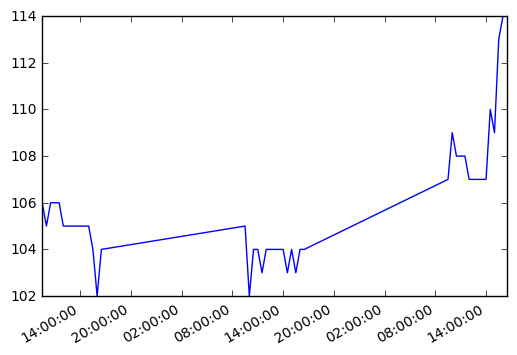

In [11]:
dt['PPS-W1']['close'].plot()


In [21]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
FF.create_candlestick(dt['PPS-W1']['open'], dt['PPS-W1']['high'], dt['PPS-W1']['low'], dt['PPS-W1']['close'], dates=dt['PPS-W1'].index)


{'data': [{'boxpoints': False,
   'fillcolor': '#3D9970',
   'line': {'color': '#3D9970'},
   'name': 'Increasing',
   'showlegend': False,
   'type': 'box',
   'whiskerwidth': 0,
   'x': [Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-27 10:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 09:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 10:30:00'),
    Timestamp('2017-03-28 12:00:00'),
    Timestamp('2017-03-28 12:00:00'),
    Timestamp('2017-03-28 12:00:00'),
    Timestamp('20

In [102]:
dt['PPS-W1'][7].resample('2H').ohlc()

open                        high                       \
                      open   high    low  close   open   high    low  close   
2017-03-27 08:00:00  106.0  106.0  106.0  106.0  106.0  106.0  106.0  106.0   
2017-03-27 10:00:00  106.0  106.0  105.0  106.0  108.0  108.0  106.0  106.0   
2017-03-27 12:00:00  106.0  106.0  106.0  106.0  106.0  106.0  106.0  106.0   
2017-03-27 14:00:00  105.0  105.0  105.0  105.0  105.0  105.0  105.0  105.0   
2017-03-27 16:00:00  104.0  104.0  104.0  104.0  104.0  104.0  104.0  104.0   
2017-03-27 18:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-27 20:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-27 22:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 06:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 08:00:00  104.0  104.0  104.0  104.0  105.0  105.0  105.0  105.0   
2017-03-28 10:00:00  105.0  105.0  102.0  104.0  105.0  105.0  104.0  104.0   
2017-03-28 12:00:00  103.0  103.0  103.0  103.0  104.0  104.0  104.0  104.0   
2017-03-28 14:00:00  104.0  104.0  103.0  104.0  104.0  104.0  103.0  104.0   
2017-03-28 16:00:00  103.0  104.0  103.0  104.0  104.0  104.0  104.0  104.0   
2017-03-28 18:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 20:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-28 22:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-29 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-29 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-29 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-29 06:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-03-29 08:00:00  104.0  104.0  104.0  104.0  107.0  107.0  107.0  107.0   
2017-03-29 10:00:00  107.0  109.0  107.0  108.0  111.0  111.0  108.0  108.0   
2017-03-29 12:00:00  107.0  107.0  107.0  107.0  108.0  108.0  108.0  108.0   
2017-03-29 14:00:00  107.0  110.0  107.0  109.0  107.0  114.0  107.0  114.0   
2017-03-29 16:00:00  113.0  114.0  113.0  114.0  115.0  115.0  114.0  114.0   

                       low                       close                       
                      open   high    low  close   open   high    low  close  
2017-03-27 08:00:00  106.0  106.0  106.0  106.0  106.0  106.0  106.0  106.0  
2017-03-27 10:00:00  105.0  106.0  105.0  106.0  105.0  106.0  105.0  106.0  
2017-03-27 12:00:00  105.0  105.0  105.0  105.0  105.0  105.0  105.0  105.0  
2017-03-27 14:00:00  105.0  105.0  104.0  104.0  105.0  105.0  104.0  104.0  
2017-03-27 16:00:00  102.0  104.0  102.0  104.0  102.0  104.0  102.0  104.0  
2017-03-27 18:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-27 20:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-27 22:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 06:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 08:00:00  104.0  104.0  104.0  104.0  105.0  105.0  105.0  105.0  
2017-03-28 10:00:00  101.0  104.0  101.0  103.0  102.0  104.0  102.0  103.0  
2017-03-28 12:00:00  103.0  103.0  103.0  103.0  104.0  104.0  104.0  104.0  
2017-03-28 14:00:00  104.0  104.0  103.0  103.0  104.0  104.0  103.0  103.0  
2017-03-28 16:00:00  103.0  104.0  103.0  104.0  104.0  104.0  104.0  104.0  
2017-03-28 18:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-03-28 2

In [16]:
for sym in symbols:
    timeframes = ["1min","5min","30min","60min","D","W","M"]
    for tf in timeframes:
    #     dt['PK'][7].resample(tf).ohlc().to_csv("candle\\" +tf+'.csv')
        dt[sym][7].resample(tf).ohlc().between_time('09:30', '16:40').dropna().to_csv("candle\\" + sym +"\\many\\" +tf+".csv")


KeyError: 'ORI'

In [ ]:
for sym in symbols:
    interesting_files = glob.glob("candle\\" + sym + "\\many\\*.csv")
    df_list = []
    for filename in sorted(interesting_files):
        df_list.append(pd.read_csv(filename))
    full_df = pd.concat(df_list)

    full_df.to_csv("candle\\" + sym + "\\output.csv")

In [76]:
for sym in symbols:
    stock[sym]['Datetime'] = pd.to_datetime(stock[sym][1] + ' ' + stock[sym][2])

# print (popx.set_index('timestamps'))

KeyError: 1

In [114]:
for sym in symbols:
    dt[sym] = stock[sym].set_index(pd.DatetimeIndex(stock[sym]['Datetime']))